# Part 1: Exploratory Data Analysis

## Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Import

In [2]:
# Read in raw data
df = pd.read_json('logins.json')

## Explore Raw Data

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.shape

(93142, 1)

In [5]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [6]:
df.isnull().values.any()

False

## Data Wrangling

In [7]:
# Sort values by date and reset index
df_sorted = df.sort_values(by='login_time')
df_sorted = df.reset_index(drop=True)

In [8]:
# Convert Series into Dataframe and set index to login time column
df_datetime = df_sorted.set_index('login_time')
print(df_datetime.head())

Empty DataFrame
Columns: []
Index: [1970-01-01 20:13:18, 1970-01-01 20:16:10, 1970-01-01 20:16:37, 1970-01-01 20:16:36, 1970-01-01 20:26:21]


In [9]:
# Add a column to count each login time
df_datetime['count'] = 1

In [10]:
df_datetime.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [11]:
# Resample dataframe to 15 minute intervals 
# and sum number of logins at each interval
df_15min = df_datetime.resample('15T').sum()

# Reset index
df_15min = df_15min.reset_index()

In [12]:
df_15min.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


## Data Visualization

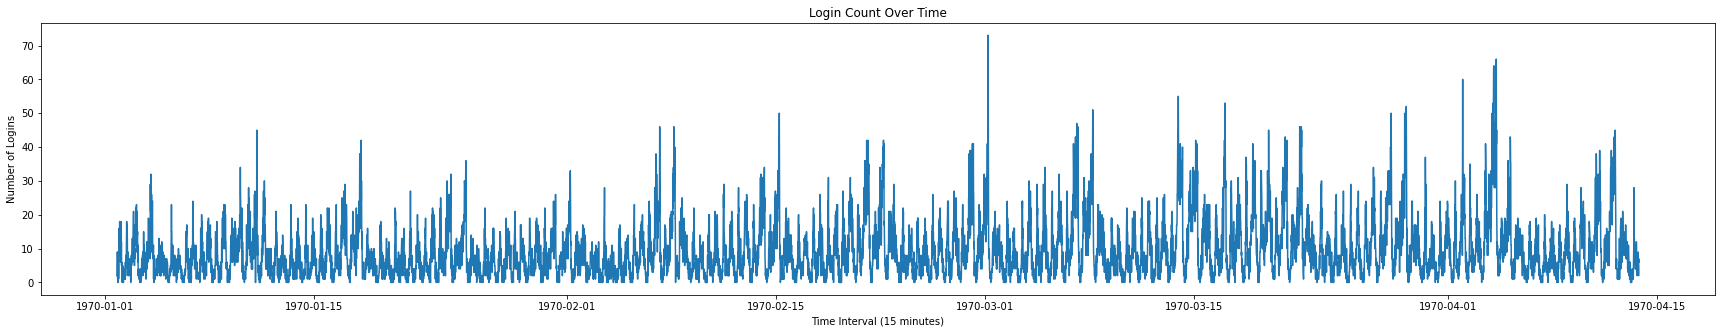

In [13]:
# Plot login counts over time with 15 minute intervals
_ = plt.figure(figsize = (30,5))
_ = plt.tight_layout()
_ = plt.plot(df_15min['login_time'], df_15min['count'])
_ = plt.title('Login Count Over Time')
_ = plt.xlabel('Time Interval (15 minutes)')
_ = plt.ylabel('Number of Logins')
plt.show()

In the above graph, the underlying pattern is hard to detect. To get a better understanding, can try using larger bins and looking at each month individually.

### 1 Hour Bins

In [14]:
# Resample dataframe to 1 hour intervals and sum number of logins at each interval
df_1hour = df_datetime.resample('1H').sum()

# Reset index
df_1hour = df_1hour.reset_index()

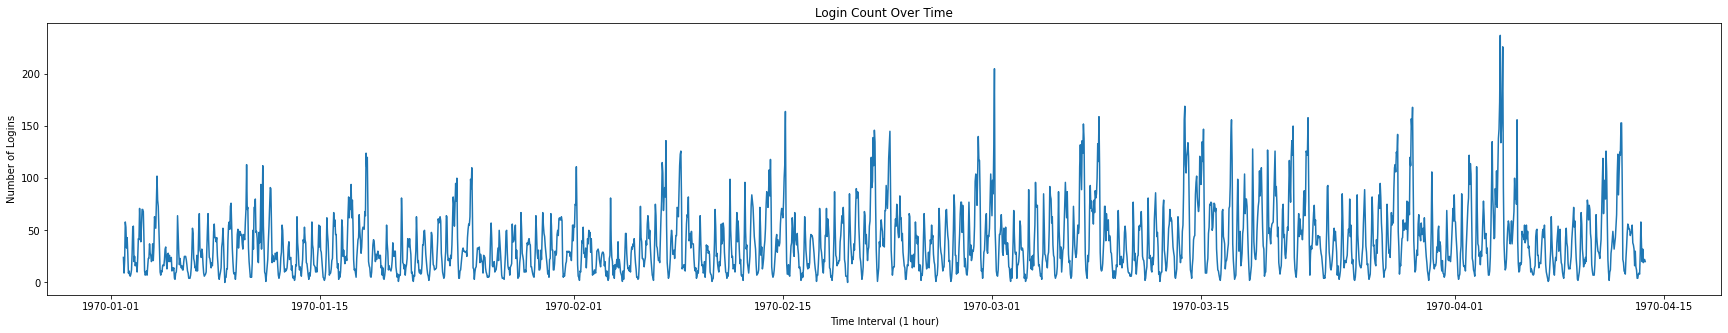

In [15]:
# Plot login counts over time with 1 hour intervals
_ = plt.figure(figsize = (30,5))
_ = plt.tight_layout()
_ = plt.plot(df_1hour['login_time'], df_1hour['count'])
_ = plt.title('Login Count Over Time')
_ = plt.xlabel('Time Interval (1 hour)')
_ = plt.ylabel('Number of Logins')
plt.show()

The underlying trend is more clear than in graph 1 but still difficult to detect. 

Try focusing on each month individually.

### Graphs by Month

In [16]:
# Create separate dataframes for each month in full dataframe (January, February, and March)
df_jan = df_1hour[df_1hour['login_time'].dt.month == 1]
df_feb = df_1hour[df_1hour['login_time'].dt.month == 2]
df_mar = df_1hour[df_1hour['login_time'].dt.month == 3]

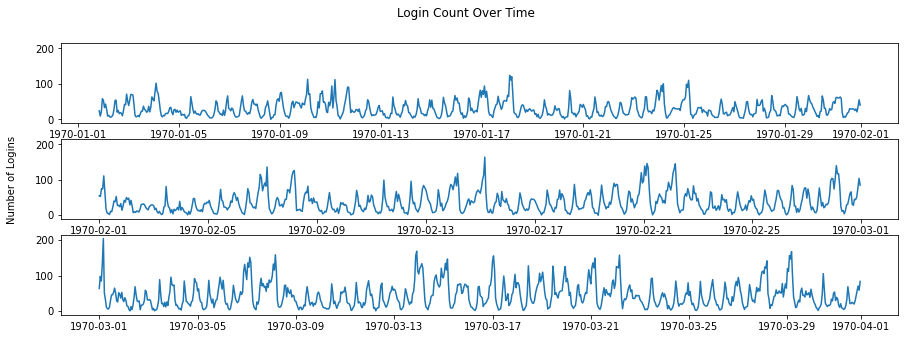

In [17]:
# Plot login counts for each month with 1 hour intervals
fig, axs = plt.subplots(3, figsize=(15,5),sharey=True)
_ = fig.suptitle('Login Count Over Time')
_ = axs[0].plot(df_jan['login_time'], df_jan['count'])
_ = axs[1].plot(df_feb['login_time'], df_feb['count'])
_ = axs[2].plot(df_mar['login_time'], df_mar['count'])
_ = fig.text(0.075, 0.5, 'Number of Logins', va='center', rotation='vertical')
plt.show()

Appears each day has a peak that goes close to zero at some point. Next will see how day of week and time of day influence login time.

### Day of Week

In [18]:
# Add a column for day of week
df_1hour['day_of_week'] = df_1hour['login_time'].dt.day_name()

In [19]:
# Group by day of week and average the login counts
df_day = df_1hour.groupby('day_of_week').mean()
df_day = df_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

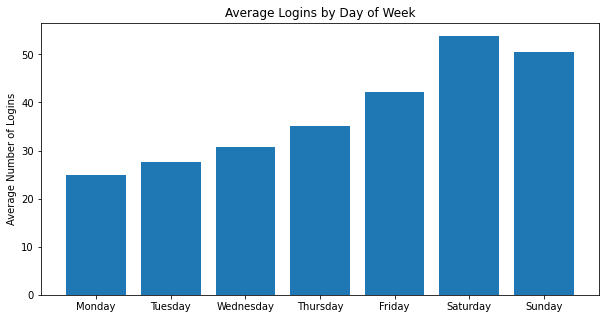

In [20]:
# Plot average number of login counts by day of week
_ = plt.figure(figsize=(10,5))
_ = plt.bar(df_day.index, df_day['count'])
_ = plt.title('Average Logins by Day of Week')
_ = plt.ylabel('Average Number of Logins')
plt.show()

Logins increase throughout the week with the busiest days being Saturday and Sunday.

### Hour of Day

In [21]:
# Add a column for hour of day
df_1hour['hour'] = df_1hour['login_time'].dt.hour

In [22]:
# Group by hour of day and average the login counts
df_hours = df_1hour.groupby('hour').mean()

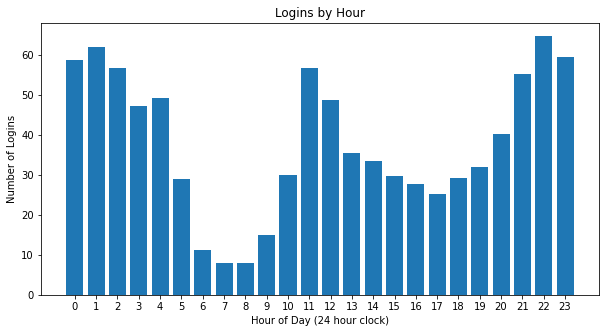

In [23]:
# Plot average number of login counts by hour of day
_ = plt.figure(figsize=(10,5))
_ = plt.bar(df_hours.index, df_hours['count'])
_ = plt.xticks(np.arange(0,24)) # Adjust x-axis label ticks so each hour shown
_ = plt.title('Logins by Hour')
_ = plt.xlabel('Hour of Day (24 hour clock)')
_ = plt.ylabel('Number of Logins')
plt.show()

Late night (9pm to 2am) and around noon (11am-12pm) seem to be peak login hours. This might reflect more individuals having free time late at night and on their lunch break around noon.

Mornings (6am-9am) are the slowest for logins. Possibly due to more people getting ready for work.

Now, let's combine hours and day of week.

### Hour of Day by Day of Week

In [24]:
# Convert dataframe so indexed by hour of day and columns list day of week
# Resulting rows show average login count by hour and day of week
df_hourofday = pd.pivot_table(df_1hour, values='count', index='hour', columns='day_of_week', aggfunc=np.mean)
# Reorder columns into calendar order
df_hourofday = pd.DataFrame(df_hourofday[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])
# Stack day of week and name the stack
df_hourofday = df_hourofday.stack(level=['day_of_week'])
df_hourofday.name = 'avg_logins'
# Reset the index
df_hourofday = df_hourofday.reset_index()

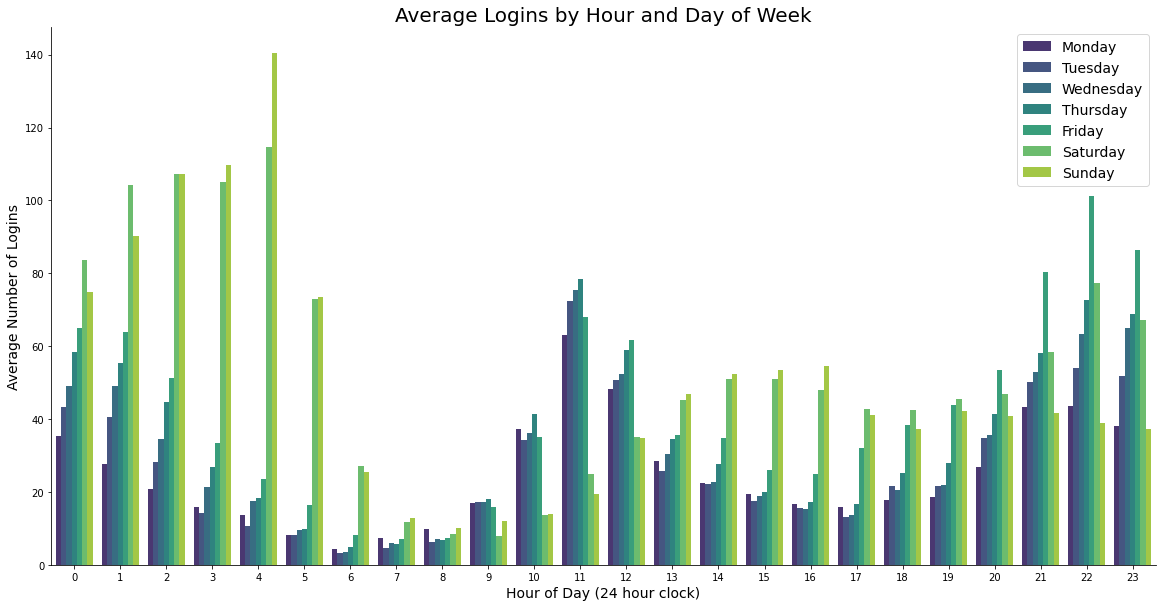

In [25]:
# Plot hour of day vs average number of logins adjusting for day of week
_ = sns.catplot(x='hour', y='avg_logins', data=df_hourofday, kind = 'bar', 
            hue='day_of_week', palette='viridis', height=8, aspect=2, legend=False)
_ = plt.legend(loc='best', fontsize=14)
_ = plt.title('Average Logins by Hour and Day of Week', fontsize=20)
_ = plt.xlabel('Hour of Day (24 hour clock)', fontsize=14)
_ = plt.ylabel('Average Number of Logins', fontsize=14)
plt.show()

Towards the end of the week (Friday-Sunday) late night (1am-4am) logins increase in frequency likely due to more individuals staying up later/ not having to be up early the next day. 

Weekday logins are most common around noon(11am-12pm) likely due to more individuals taking their lunch.

# Part 2: Experiment and Metrics Design

**Key metric**: reimbursed toll costs

The most straighforward way to measure success is to measure the amount of reimbursed toll costs. The higher the reimbursed toll costs the more successful the experiment.

**Experiment**: Collect 100 participants from each driver partner. From each group randomly select 50 drivers as controls (no toll reimbursement) and 50 drivers as experimentals (toll reinbursement). Provide ride logs to each driver where they fill out: pick up location, drop of location, area surveyed, price of ride, miles drove, toll cost. 

**Statistical test**: T-test to compare the means of the two independent groups. Paired - groups from same population. One-tailed - only care if toll reinbursement group used toll bridge more often.

**Criteria for success**: p-value <= 0.05, 5% probability that the resulting t-value occured by chance.

# Part 3: Predictive Modeling

## Import Relevant Packages

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, classification_report
import timeit
from sklearn.ensemble import RandomForestClassifier

## Data Import

In [27]:
# Read in raw data
rider_retention = pd.read_json('ultimate_data_challenge.json')

## Explore Raw Data

In [28]:
rider_retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [29]:
rider_retention.shape

(50000, 12)

In [30]:
rider_retention.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [31]:
# Check for null values
rider_retention.isnull().values.any()

True

In [32]:
# Find null values in dataframe
rider_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Remove Null Values

In [33]:
# Less than 20% missing values so will fill NaNs rather than drop column 
# Fill rating missing values with median of respective columns
fillwithmedian = ['avg_rating_of_driver', 'avg_rating_by_driver']
rider_retention[fillwithmedian] = rider_retention[fillwithmedian].fillna(rider_retention[fillwithmedian].median())

In [34]:
# Phone type cannot be filled and since less than 1% missing will just drop those rows
rider_retention = rider_retention.dropna()

In [35]:
# Verify no null values remain
rider_retention.isnull().values.any()

False

### Check All Columns Values

Verify no errors in remaining columns

In [36]:
rider_retention['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [37]:
rider_retention['trips_in_first_30_days'].unique()

array([  4,   0,   3,   9,  14,   2,   1,   6,  24,   5,   7,  11,  73,
         8,  10,  22,  15,  13,  17,  20,  12,  42,  27,  26,  18,  16,
        40,  28,  19,  23,  33,  48,  31,  71,  25,  21,  34,  29,  30,
        32,  47,  37,  53,  43,  44,  38,  39,  49,  55, 125,  41,  50,
        63,  35,  54,  56,  36,  51,  58])

In [38]:
rider_retention['signup_date'].unique()

array(['2014-01-25', '2014-01-29', '2014-01-06', '2014-01-10',
       '2014-01-27', '2014-01-09', '2014-01-24', '2014-01-28',
       '2014-01-21', '2014-01-03', '2014-01-13', '2014-01-15',
       '2014-01-11', '2014-01-12', '2014-01-02', '2014-01-31',
       '2014-01-19', '2014-01-16', '2014-01-26', '2014-01-05',
       '2014-01-17', '2014-01-22', '2014-01-18', '2014-01-20',
       '2014-01-04', '2014-01-30', '2014-01-07', '2014-01-01',
       '2014-01-08', '2014-01-23', '2014-01-14'], dtype=object)

In [39]:
rider_retention['avg_rating_of_driver'].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, 4.9, 4.5, 4. , 3.9, 4.8, 2.5, 3.7,
       1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2, 2.6,
       3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

In [40]:
rider_retention['avg_surge'].unique()

array([1.1 , 1.  , 1.14, 1.19, 1.38, 1.21, 1.17, 1.02, 1.05, 1.5 , 2.  ,
       1.25, 1.04, 1.88, 1.33, 1.56, 1.06, 1.03, 1.09, 1.35, 3.5 , 1.11,
       1.63, 2.5 , 1.32, 1.3 , 1.75, 2.25, 1.2 , 1.13, 1.08, 1.15, 4.  ,
       1.12, 1.22, 1.29, 1.23, 1.01, 1.07, 1.18, 1.45, 2.75, 2.63, 1.46,
       2.07, 1.27, 3.  , 1.36, 1.96, 1.42, 1.44, 1.54, 1.16, 1.31, 1.58,
       1.92, 1.67, 1.26, 4.75, 1.41, 3.25, 1.24, 2.13, 1.6 , 1.57, 1.34,
       1.52, 1.69, 5.  , 1.4 , 1.37, 1.7 , 1.78, 1.43, 1.94, 1.64, 1.83,
       1.28, 1.85, 1.55, 1.48, 1.39, 2.88, 4.25, 1.47, 1.51, 1.9 , 1.68,
       4.5 , 1.66, 2.33, 1.65, 1.71, 2.17, 2.38, 1.61, 2.08, 3.75, 8.  ,
       1.77, 1.49, 2.42, 1.59, 1.8 , 2.19, 1.53, 1.81, 5.75, 1.79, 2.44,
       2.67, 2.31, 2.1 , 2.2 , 3.63])

In [41]:
rider_retention['last_trip_date'].unique()

array(['2014-06-17', '2014-05-05', '2014-01-07', '2014-06-29',
       '2014-03-15', '2014-06-06', '2014-01-25', '2014-01-29',
       '2014-02-01', '2014-01-05', '2014-05-30', '2014-01-10',
       '2014-03-12', '2014-06-08', '2014-01-28', '2014-01-16',
       '2014-06-28', '2014-07-01', '2014-06-24', '2014-06-03',
       '2014-03-16', '2014-04-29', '2014-05-02', '2014-06-13',
       '2014-05-18', '2014-01-03', '2014-01-22', '2014-03-05',
       '2014-02-27', '2014-02-07', '2014-06-14', '2014-06-10',
       '2014-02-28', '2014-01-17', '2014-02-21', '2014-06-25',
       '2014-04-26', '2014-06-30', '2014-06-23', '2014-05-10',
       '2014-01-26', '2014-03-17', '2014-06-18', '2014-04-19',
       '2014-01-19', '2014-06-19', '2014-02-15', '2014-06-01',
       '2014-05-16', '2014-06-15', '2014-03-10', '2014-04-20',
       '2014-03-29', '2014-02-02', '2014-05-09', '2014-05-04',
       '2014-03-19', '2014-04-23', '2014-01-01', '2014-01-08',
       '2014-04-27', '2014-01-30', '2014-02-03', '2014-

In [42]:
rider_retention['phone'].unique()

array(['iPhone', 'Android'], dtype=object)

In [43]:
print(rider_retention['surge_pct'].min())
print(rider_retention['surge_pct'].max())

0.0
100.0


In [44]:
rider_retention['ultimate_black_user'].unique()

array([ True, False])

In [45]:
print(rider_retention['weekday_pct'].min())
print(rider_retention['weekday_pct'].max())

0.0
100.0


In [46]:
print(rider_retention['avg_dist'].min())
print(rider_retention['avg_dist'].max())

0.0
160.96


In [47]:
rider_retention['avg_rating_by_driver'].unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, 4.4, 4.6, 3.7, 4.3, 3.5,
       2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8, 1.5,
       2.7])

### Correct Data Types 

In [48]:
# Change date columns from strings to datetime objects
datetype = ['signup_date', 'last_trip_date']
rider_retention[datetype] = rider_retention[datetype].astype('datetime64[ns]')

### Add Useful Columns

In [49]:
# Add column to view users length of use in months
rider_retention['length_of_use_months'] = ((rider_retention['last_trip_date'] - rider_retention['signup_date'])/np.timedelta64(1, 'M'))

In [50]:
# Define active as users who have taken a trip in the last 30 days
active_use_max = rider_retention['last_trip_date'].max()
active_use_min = active_use_max - pd.Timedelta('30 days')

# Add a column to see if a user is currently active
rider_retention['active_user'] = (rider_retention['last_trip_date'] > active_use_min)

## Data Description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday
- length_of_use(months): number of months app used for; calculated as difference between date account registered and date of last trip
- active_user: TRUE if the user has taken a ride within the last 30 days

## Exploratory Analysis

In [51]:
rider_retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,length_of_use_months,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,4.698248,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,3.154069,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.032855,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,5.585330,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.544180,False


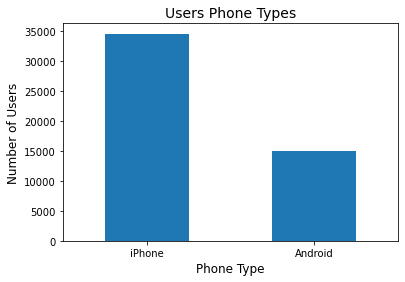

In [52]:
# Plot user phone types
_ = rider_retention['phone'].value_counts().plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('Users Phone Types', fontsize=14)
_ = plt.xlabel('Phone Type', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)
plt.show()

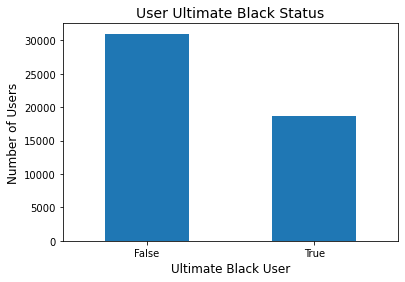

In [53]:
# Plot user ultimate black user status
_ = rider_retention['ultimate_black_user'].value_counts().plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('User Ultimate Black Status', fontsize=14)
_ = plt.xlabel('Ultimate Black User', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)
plt.show()

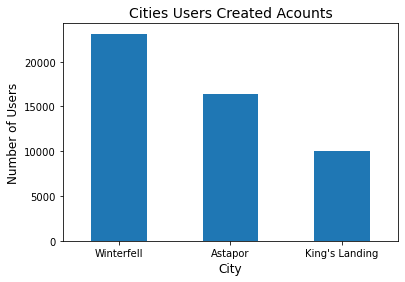

In [54]:
# Plot user cities
_ = rider_retention['city'].value_counts().plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('Cities Users Created Acounts', fontsize=14)
_ = plt.xlabel('City', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)
plt.show()

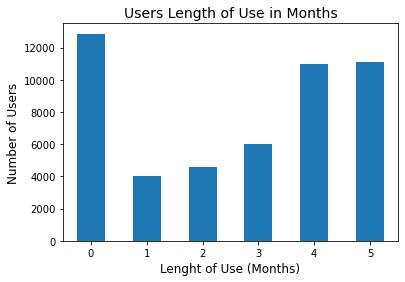

In [55]:
# Plot users lenght of use in months
# View months are integers to simplify graph
_ = rider_retention['length_of_use_months'].astype('int').value_counts(sort=False).plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('Users Length of Use in Months', fontsize=14)
_ = plt.xlabel('Lenght of Use (Months)', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)
plt.show()

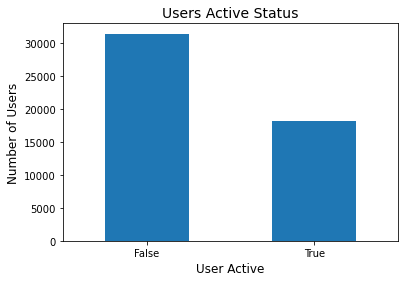

In [56]:
# Plot users active status
_ = rider_retention['active_user'].value_counts().plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('Users Active Status', fontsize=14)
_ = plt.xlabel('User Active', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)
plt.show()

#### What fraction of the observed users were retained?

In [57]:
# Count how many users active
active_num_users = rider_retention['active_user'][rider_retention['active_user'] == True].count() 
# Count total number of users
total_num_users = rider_retention['active_user'].count()
# Find percent of users active
pct_users_active = active_num_users/total_num_users

print("Percent users active: {:.1%}".format(pct_users_active))

Percent users active: 36.7%


### Dummy Columns for Categorical Features

In [58]:
# Create dummy columns for all categorical columns
rr_dumb = pd.get_dummies(rider_retention)

In [59]:
# View resulting dataframe
rr_dumb.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,length_of_use_months,active_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,4.698248,True,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,3.154069,False,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0.032855,False,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,5.585330,True,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,1.544180,False,0,0,1,1,0


### Heat Map of Feature Correlations

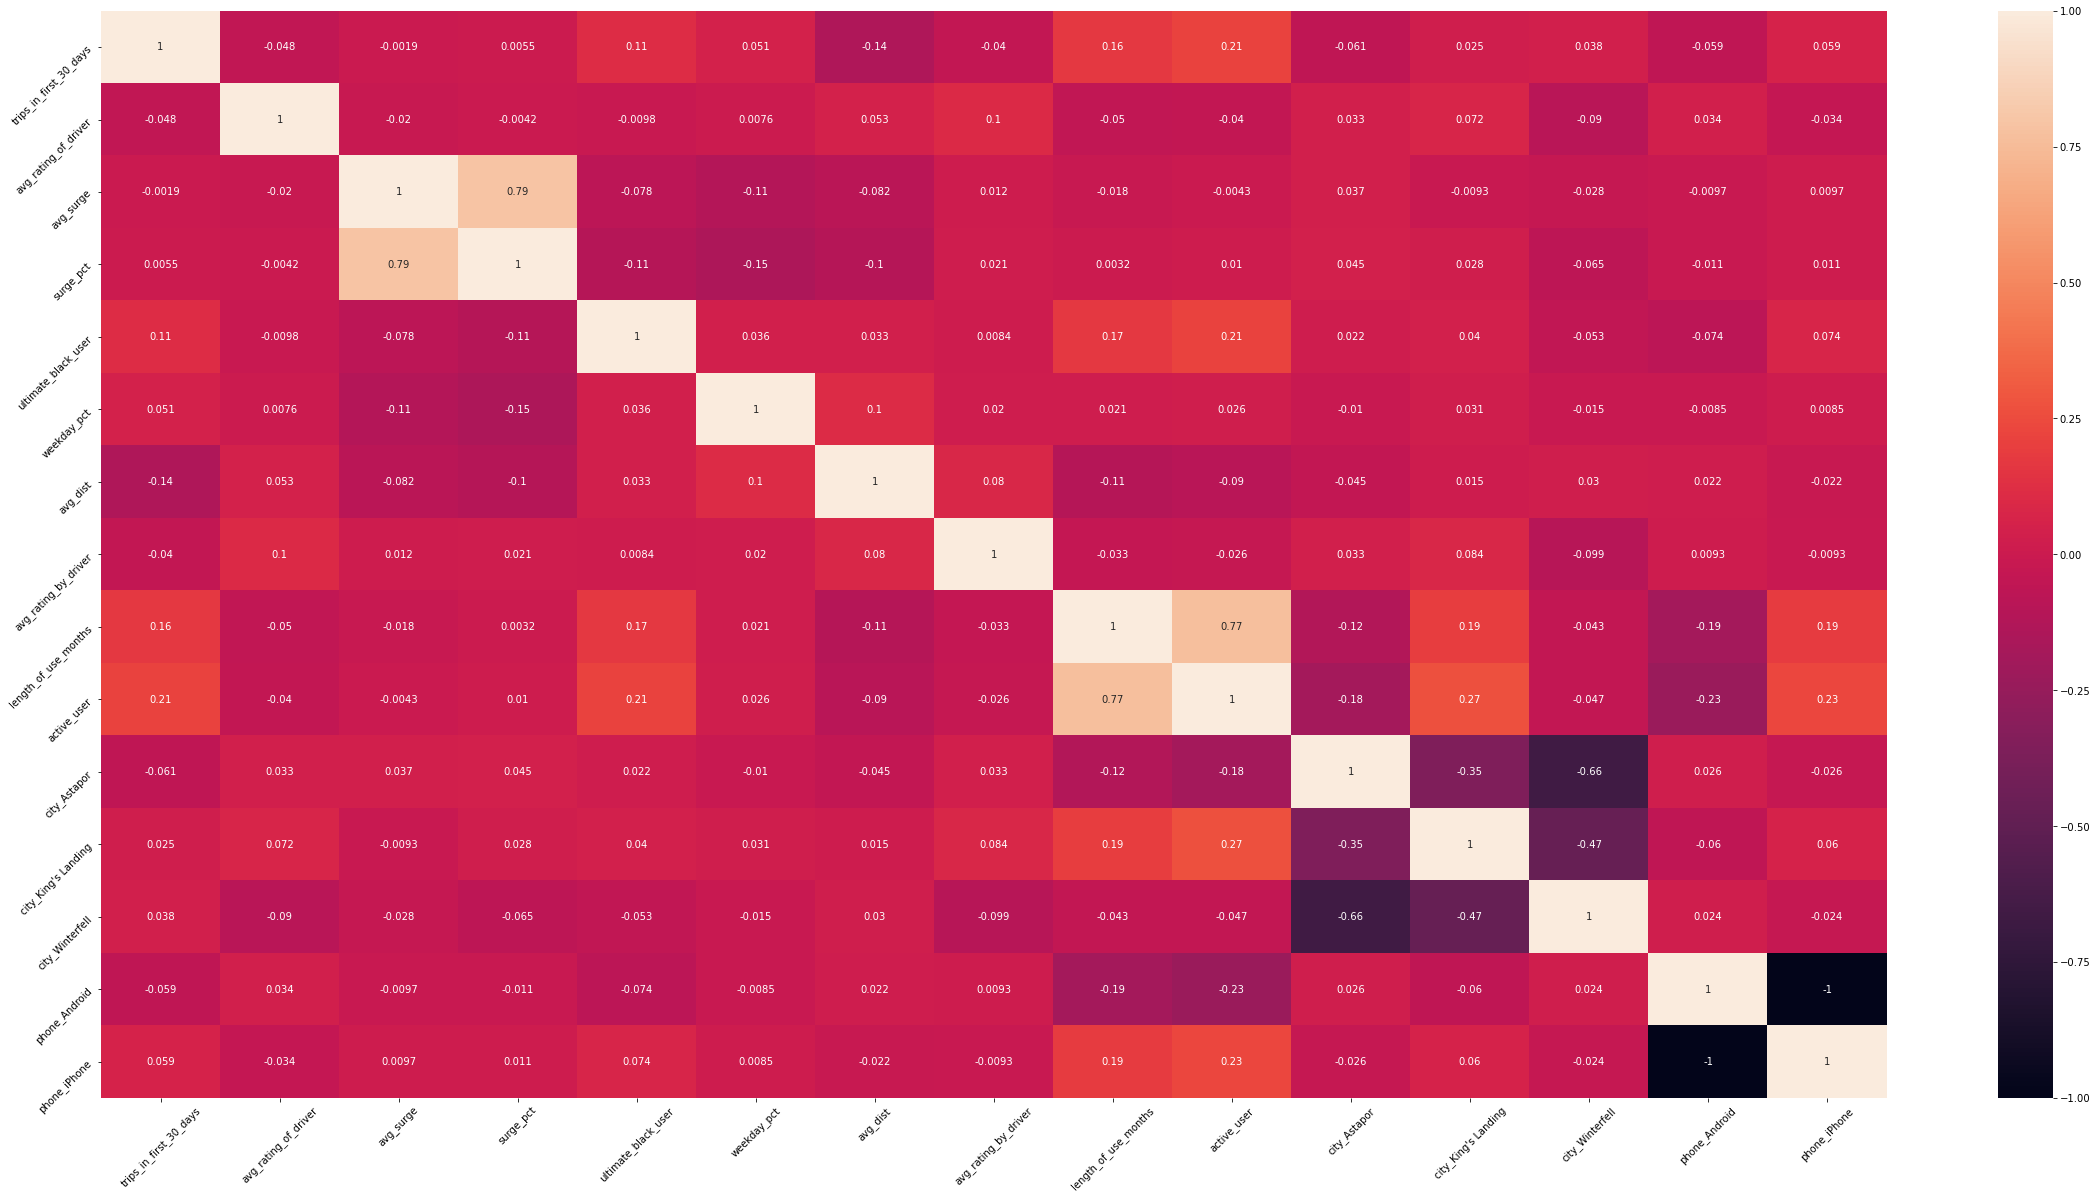

In [60]:
# Plot heatmap of column correlations
_ = plt.figure(figsize=(40,20))
_ = sns.heatmap(rr_dumb.corr(), annot=True)
_ = plt.xticks(rotation=45) 
_ = plt.yticks(rotation=45)
plt.show()

#### Correlations of interest
Strong correlations of interest:
- Active user & length of use: 0.78

Some weak correlation (< +/-0.15-0.3) are listed below:
- Length of use & trips in first 30 days: 0.16
- Weekend percentage & surge percentage: -0.15
- Length of use & ultimate black user: 0.17
- Length of use & iPhone: 0.19
- Length of use & Android: -0.19
- Length of use & King's Landing: 0.19
- Active user & Trips in first 30 days: 0.21
- Active user & Ultimate black user: 0.21
- Active user & King's Landing: 0.27
- Active user & iPhone: 0.23
- Active user & Android: -0.23



There are moderate to strong correlations between cities but this is not interesting since if in one city can't be in another. This is also the case for type of phone, can either have an Android or an iPhone. 

### Plot Strong Correlation

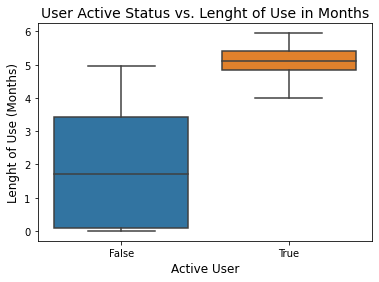

In [61]:
_ = sns.boxplot(x=rr_dumb['active_user'], y = rr_dumb['length_of_use_months'])
_ = plt.title('User Active Status vs. Lenght of Use in Months', fontsize=14)
_ = plt.xlabel('Active User', fontsize=12)
_ = plt.ylabel('Lenght of Use (Months)', fontsize=12)
plt.show()

Active users tend to have longer length of use than inactive users

### Scale and Remove Outliers

In [62]:
# Initialize StandardScaler
scaler = StandardScaler()

# Construct dataframe with columns that do not need to be scaled
rr_dumb_scaled = pd.DataFrame(rr_dumb[["active_user", "length_of_use_months", 
                                       "signup_date", "last_trip_date", 
                                       "ultimate_black_user", "city_Astapor",
                                       "city_King's Landing", "city_Winterfell", 
                                       "phone_Android","phone_iPhone"]])

In [63]:
'''
Scale and remove outliers from remaining columns
First for loop standardizing columns
Second for loop removes outliers (values 3 standard deviations from the mean)
'''

# List columns that need to be scaled
scale_columns = ['trips_in_first_30_days', 'avg_rating_of_driver',
                 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 
                 'avg_rating_by_driver']

# Create for loop to scale all columns listed in scale_columns
for col in rr_dumb[scale_columns]:
    # Fit and transform columns using Standard Scaler
    col_scaled = col + '_scaled' # Create new column name by taking old name and adding _scaled
    scaler.fit(rr_dumb[[col]])
    rr_dumb_scaled[col_scaled] = scaler.transform(rr_dumb[[col]])
    
#List columns that need to have outliers removed
outlier_columns = ['trips_in_first_30_days_scaled', 'avg_rating_of_driver_scaled',
                   'avg_surge_scaled', 'surge_pct_scaled', 'weekday_pct_scaled', 
                   'avg_dist_scaled', 'avg_rating_by_driver_scaled']
    
# Create for loop to remove outliers from all columns listed in outlier_columns
for col in rr_dumb_scaled[outlier_columns]:
    # Remove outliers (values more than 3 standard deviations from the mean)
    mean = rr_dumb_scaled[col_scaled].mean()
    std = rr_dumb_scaled[col_scaled].std()
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    rr_dumb_scaled = rr_dumb_scaled[(rr_dumb_scaled[col_scaled] < upper) 
                                & (rr_dumb_scaled[col_scaled] > lower)]

In [64]:
# View resulting dataframe
rr_dumb_scaled.head()

,active_user,length_of_use_months,signup_date,last_trip_date,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,trips_in_first_30_days_scaled,avg_rating_of_driver_scaled,avg_surge_scaled,surge_pct_scaled,weekday_pct_scaled,avg_dist_scaled,avg_rating_by_driver_scaled
0,True,4.698248,2014-01-25,2014-06-17,True,0,1,0,0,1,0.454159,0.087233,0.112318,0.326417,-0.395941,-0.373113,0.495597
1,False,3.154069,2014-01-29,2014-05-05,False,1,0,0,1,0,-0.600342,0.608234,-0.336789,-0.444014,-0.293477,0.436461,0.495597
2,False,0.032855,2014-01-06,2014-01-07,False,1,0,0,0,1,0.190534,-0.607435,-0.336789,-0.444014,1.054746,-0.884608,0.495597
3,True,5.585330,2014-01-10,2014-06-29,True,0,1,0,0,1,1.772286,-0.086434,0.291961,0.556545,0.515457,-0.604167,0.271601
4,False,1.544180,2014-01-27,2014-03-15,False,0,0,1,1,0,3.090412,-0.433768,0.516515,0.146316,0.580172,-0.468357,0.271601


In [65]:
# Check for null values and correct dtypes
rr_dumb_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44668 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   active_user                    44668 non-null  bool          
 1   length_of_use_months           44668 non-null  float64       
 2   signup_date                    44668 non-null  datetime64[ns]
 3   last_trip_date                 44668 non-null  datetime64[ns]
 4   ultimate_black_user            44668 non-null  bool          
 5   city_Astapor                   44668 non-null  uint8         
 6   city_King's Landing            44668 non-null  uint8         
 7   city_Winterfell                44668 non-null  uint8         
 8   phone_Android                  44668 non-null  uint8         
 9   phone_iPhone                   44668 non-null  uint8         
 10  trips_in_first_30_days_scaled  44668 non-null  float64       
 11  avg_rating_of_d

## Test Train Split

In [66]:
# Set dependent variable to active user column
y = rr_dumb_scaled['active_user']

# Use all remaining columns (besides date columns) as independent variables
X = rr_dumb_scaled.drop(['active_user', 'signup_date', 'last_trip_date'], axis=1)

In [67]:
# Train test split data, keeping 25% of data for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Print train and test shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33501, 14) (33501,)
(11167, 14) (11167,)


## Modeling

Learning type: Supervised learning
- Data labelled as active or inactive

Model Type: Binary, classification probelm
- Discrete variables with two types; either active or not 

Evaluation Metric: F1 score with micro average
 - Dependent variable has class imbalance
 - Micro-average is preferable if there is a class imbalance problem
 
Binary, classification models:
- Support Vector Machines: performs poorly for overlapping classes so will not use in this case
- Naive Bayes: assumes all features are independent and contribute equally so will not use in this case
- K-Nearest Neighbors: does not work well on imbalanced data so will not use in this case
- Logistic regression: not very powerful and requires all important variables to be present. Since most features are not strongly correlated with dependent variable will not use in this case
- Decision trees: prone to overfitting and sensitive to data so will not use in this case
- Random forest: performs well on imbalanced data and handles missing data well
- XGBoost: good model performancena and less prone to overfitting but harder to tune

**Random forest will be used in this case**
- XGBoost also a model to consider but since requires more attention to tuning will not use in the interest of time

In [68]:
# Use RandomizedSearchCV to find best parameters for Random Forest Model
param_grid_rf = {'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                 'criterion':['gini', 'entropy'],
                 'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 12, 13]}
rf = RandomForestClassifier()
cv = RandomizedSearchCV(rf, param_grid_rf, cv=5) # Split training data into 5 cross validations
cv.fit(X_train, y_train) 
print(cv.best_params_)
print(cv.best_score_)

{'n_estimators': 100, 'max_depth': 10, 'criterion': 'gini'}
0.9606280409540013


In [69]:
# Define the best parameters from the outcome of the above RandomizedSearch
best_n_estimators = cv.best_params_['n_estimators']
best_criterion = cv.best_params_['criterion']
best_max_depth = cv.best_params_['max_depth']

# Start time to predict model runtime
start = timeit.default_timer()

# Fit and predict model using best parameter
best = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion,
                                 max_depth=best_max_depth)
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

# Stop time to predict model runtime
stop = timeit.default_timer()

# Define model runtime variable
time = stop - start

In [70]:
print('Classification Report: Random Forest Classifier Model')
print('')
print(classification_report(y_test, y_pred))

Classification Report: Random Forest Classifier Model

              precision    recall  f1-score   support

       False       0.97      0.96      0.97      6893
        True       0.94      0.96      0.95      4274

    accuracy                           0.96     11167
   macro avg       0.96      0.96      0.96     11167
weighted avg       0.96      0.96      0.96     11167



In [71]:
# Define F1 score
F1score = make_scorer(f1_score, average='micro')

# Cross-validate model performance
cv_test = cross_val_score(best, X_test, y_test, cv=5, scoring=F1score)
cv_train = cross_val_score(best, X_train, y_train, cv=5, scoring=F1score)
print(cv_test)

# Find average of CV scores for test & train
cv_train_avg = cv_train.mean()
cv_train_std = cv_train.std()
cv_test_avg = cv_test.mean()
cv_test_std = cv_test.std()
print('')
print ('Mean cross validation train score: ', cv_train_avg)
print ('Standard deviation in train cv scores: ', cv_train_std)
print('')
print ('Mean cross validation test score: ', cv_test_avg)
print ('Standard deviation in test cv scores: ', cv_test_std)
print('')
print('Runtime: ', time)

[0.95792301 0.96239928 0.96239928 0.95969548 0.96729391]

Mean cross validation train score:  0.9602398880986266
Standard deviation in train cv scores:  0.0015322806855488195

Mean cross validation test score:  0.9619421918791904
Standard deviation in test cv scores:  0.0031704979220281916

Runtime:  1.9442585830001917


## Feature Importance

In [72]:
# Rank feature importance
features = X
importances = list(best.feature_importances_)
importances_sorted = np.sort(importances)
importance_table = pd.DataFrame(list(zip(X, importances_sorted)), 
                                columns =['Features', 'Importance scores'],
                                index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]) 
importance_table

,Features,Importance scores
1,length_of_use_months,0.004306
2,ultimate_black_user,0.006567
3,city_Astapor,0.007915
4,city_King's Landing,0.010283
5,city_Winterfell,0.011571
6,phone_Android,0.011884
7,phone_iPhone,0.012238
8,trips_in_first_30_days_scaled,0.013970
9,avg_rating_of_driver_scaled,0.022159
10,avg_surge_scaled,0.027752


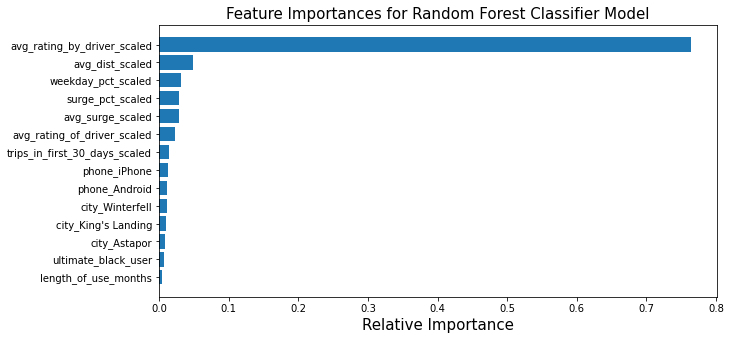

In [73]:
# Bar graph of feature importance
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
_ = plt.figure(figsize=(10, 5))
_ = plt.barh(index, importances_sorted)
_ = plt.xlabel('Relative Importance', fontsize=15)
_ = plt.yticks(index, features)
_ = plt.title('Feature Importances for Random Forest Classifier Model', fontsize=15)
plt.show()

## Take Aways

Random Forest performs well in correctly classifying users as either active or inactive. The above classification model resulted in a cross validation score of 0.96 with a standard devation of 0.0032. The optimal parameters are 100 trees, a max depth of 10, and gini for node impurity. Runtime was 1.9. Average rating by drivers was shown to be the most important feature for classification.

Moving forward, Ultimate might want to set a rubric for how drivers rate users as it seems possible users who receive low rating do not continue to use the service. The importance of this feature might also mean low rated users have a more difficult time securing a driver. Ultimate might consider gathering data on user wait time and see if there is a correlation between user rating and average weight time. If a correlation is found, Ultimate could consider creating an incentive for drivers to pick up users who are waiting for 5 minutes or longer. 